# LDDMM: how to estimate a deterministic atlas?

This is analog to a registration problem for multiple meshes.

For registration between two meshes check [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.io import DictMeshWriter
from polpo.preprocessing.mesh.registration import RigidAlignment

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "atlas_example"
ATLAS_DIR = OUTPUTS_DIR / "atlas"

OUTPUTS_DIR.mkdir(exist_ok=True)

## Loading meshes

In [4]:
subject_id = "01"

path2mesh = MeshLoader(
    subject_subset=[subject_id],
    session_subset=[1, 2, 3],
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

pipe = path2mesh + ppdict.ExtractUniqueKey(nested=True)

meshes = pipe()

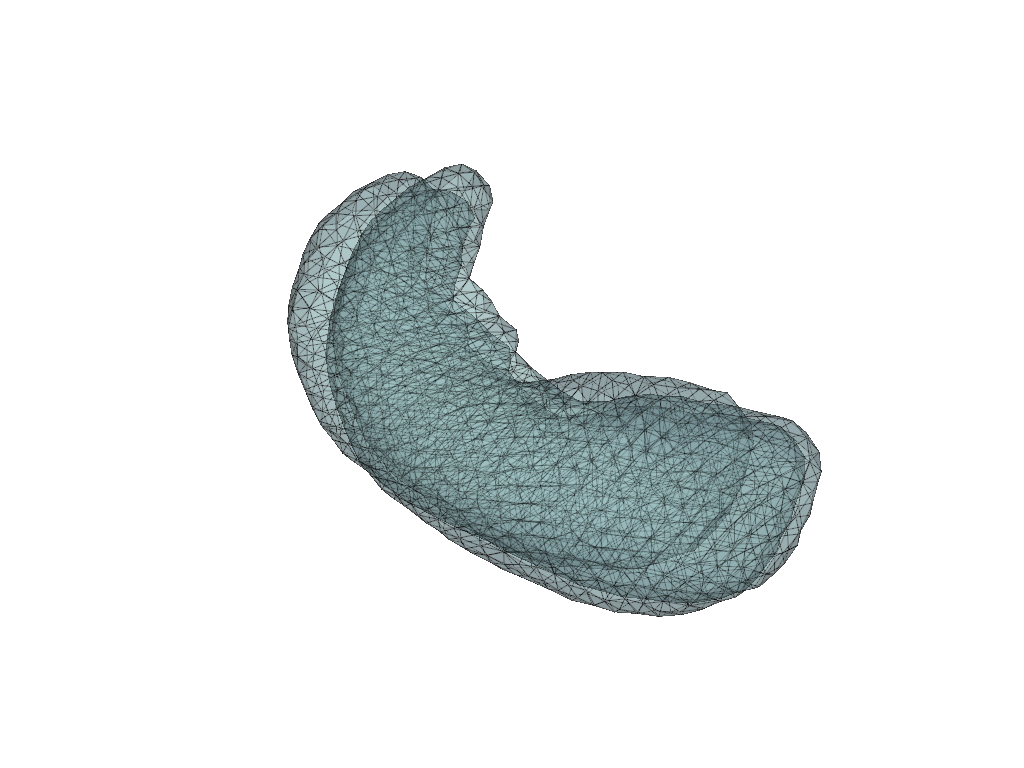

In [5]:
pl = pv.Plotter(border=False)

for mesh in meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

In [6]:
prep_pipe = RigidAlignment(max_iterations=500)

meshes = prep_pipe(meshes)

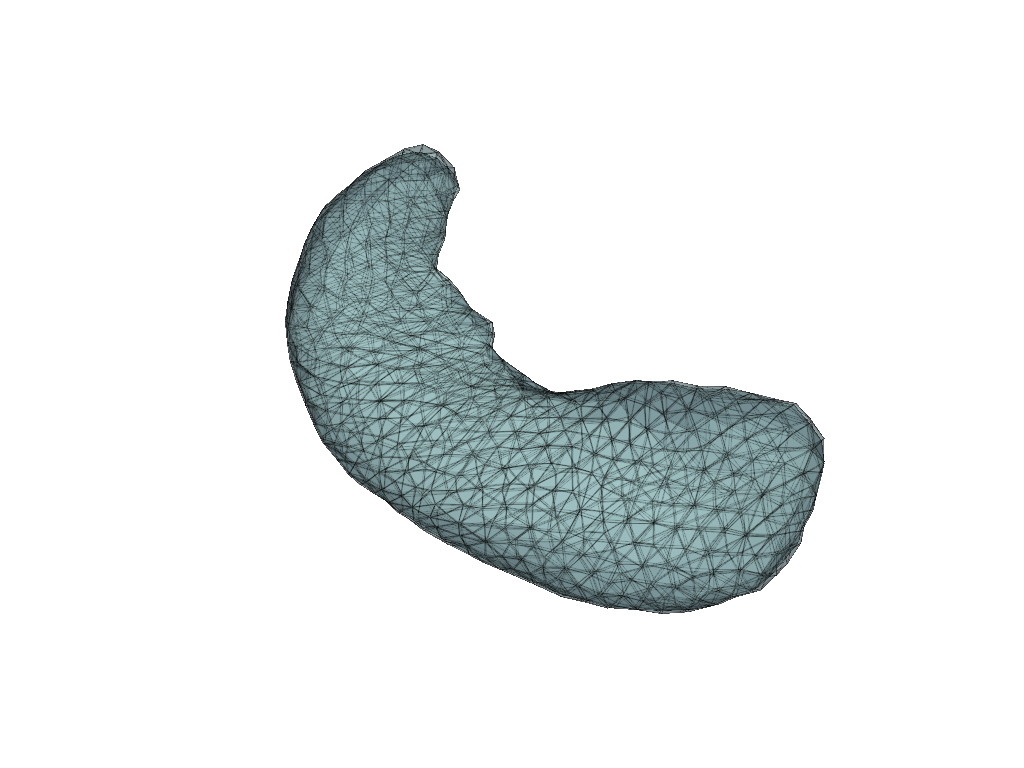

In [7]:
pl = pv.Plotter(border=False)

for mesh in meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Deterministic atlas

Save meshes in `vtk` format (as required by `deformetrica`).

In [8]:
meshes_writer = DictMeshWriter(dirname=OUTPUTS_DIR, ext="vtk")

dataset = meshes_writer(meshes)

Use LDDMM to estimate the atlas.

In [9]:
kernel_width = 10.0  # NB: influences the number of cp
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)

plddmm.learning.estimate_deterministic_atlas(
    targets=dataset,
    output_dir=ATLAS_DIR,
    initial_step_size=1e-1,
    **registration_kwargs,
)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/atlas_example/atlas/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_meth

PosixPath('results/atlas_example/atlas/DeterministicAtlas__EstimatedParameters__Template_shape.vtk')

## Visualization

Visualize the results.

In [10]:
cp = plddmm.io.load_cp(ATLAS_DIR)
momenta = plddmm.io.load_momenta(ATLAS_DIR)
template = plddmm.io.load_template(ATLAS_DIR, as_pv=True)

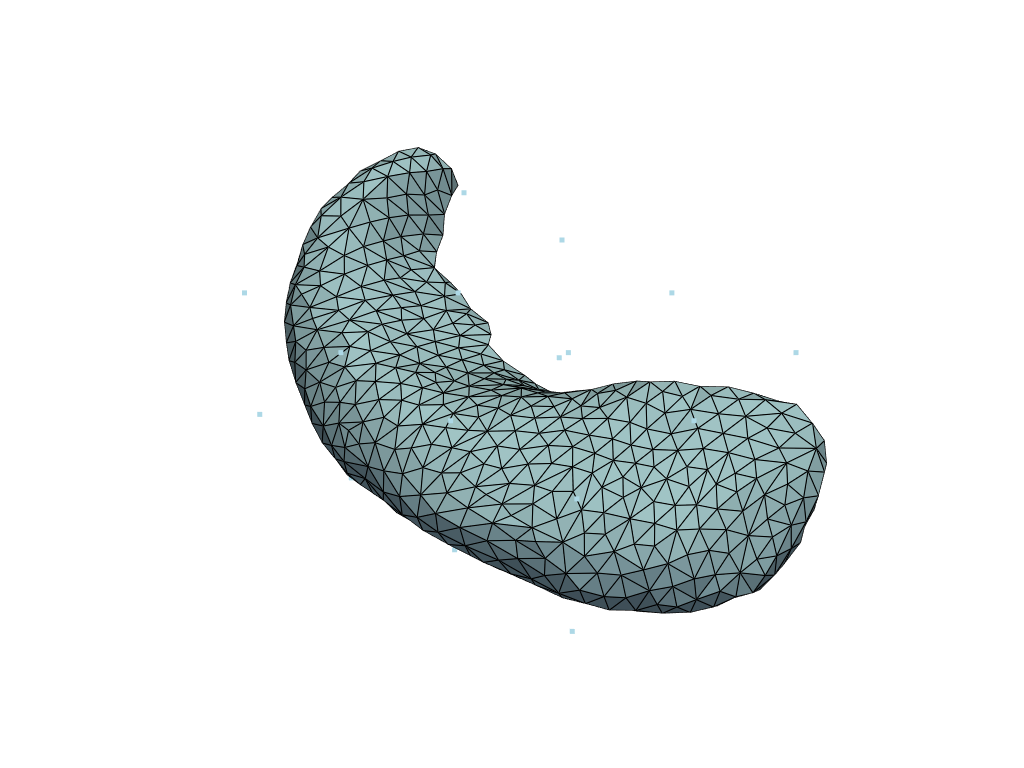

In [11]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

pl.add_mesh(pv.PolyData(cp))

pl.show()

Visualize the reconstruction errors.

In [12]:
rec_meshes = plddmm.io.load_deterministic_atlas_reconstructions(ATLAS_DIR, as_pv=True)

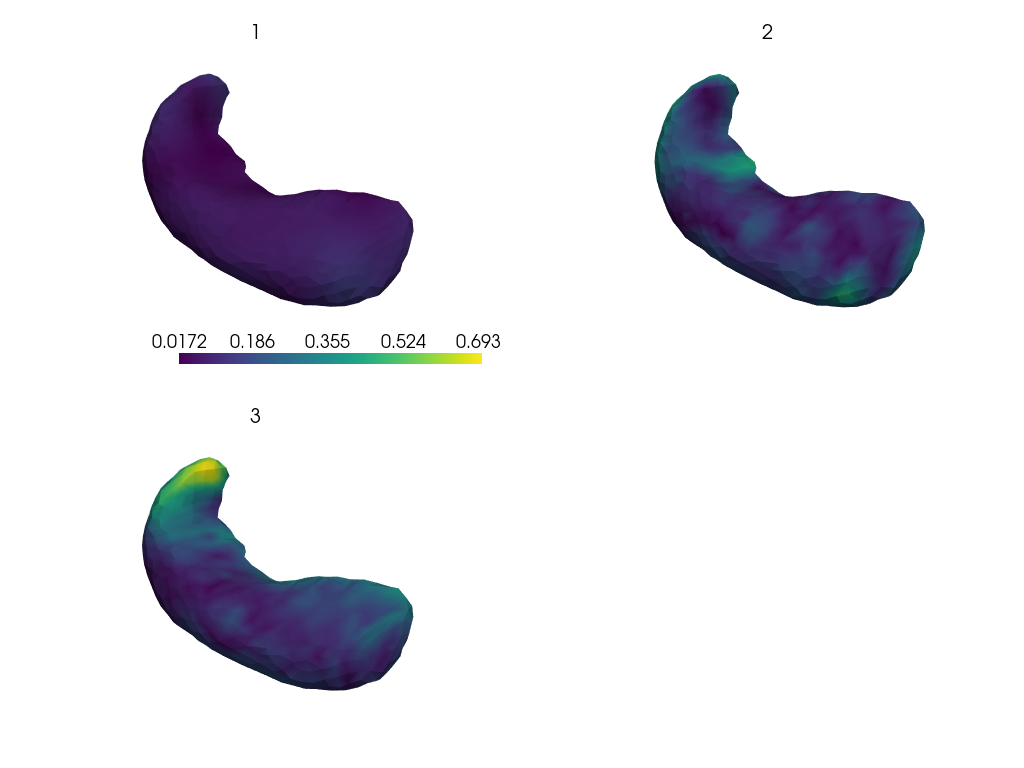

In [13]:
plot_shape = putils.plot_shape_from_n_plots(len(meshes), n_axis=2)

pl = pv.Plotter(shape=plot_shape, border=False)

for index, key in enumerate(meshes.keys()):
    mesh, rec_mesh = meshes[key], rec_meshes[key]
    pl.subplot(*putils.plot_index_to_shape(index, plot_shape[1]))

    # NB: assumes meshes are registered
    euc_res = np.linalg.norm(mesh.points - rec_mesh.points, axis=-1)
    pl.add_mesh(rec_mesh, scalars=euc_res)
    pl.add_title(str(key), font_size=8)

pl.show()

Visualize the flow from the template to each of the meshes.

In [14]:
flows = plddmm.io.load_deterministic_atlas_flows(ATLAS_DIR, as_pv=True)

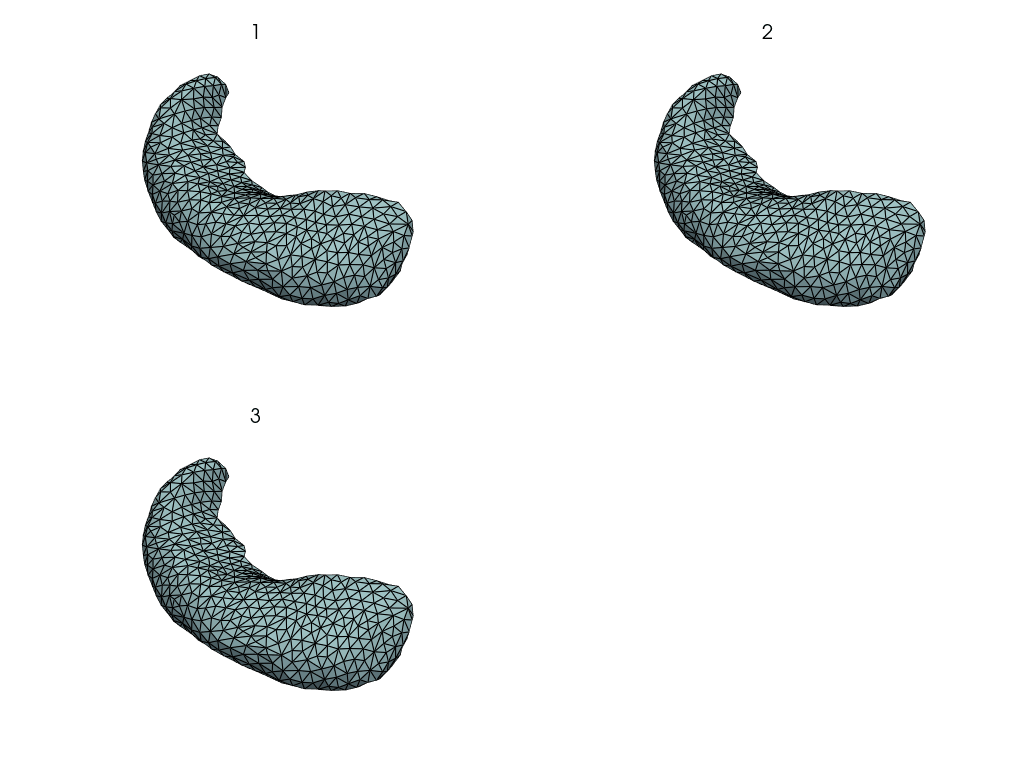

In [15]:
pl = RegisteredMeshesGifPlotter(
    shape=putils.plot_shape_from_n_plots(len(meshes), n_axis=2),
    fps=10,
    border=False,
    off_screen=True,
    notebook=False,
    subtitle=True,
)

pl.add_meshes(ppdict.DictListSwapper()(flows))
pl.close()

pl.show()

## Further reading

* [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb)

* [LDDMM: how to do regression?](./lddmm_regression.ipynb)

* [LDDMM: how To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas](./regression_across_subjects.ipynb)